In [ ]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from dotenv import load_dotenv, find_dotenv
import numpy as np

load_dotenv()

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.xcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


TABLE_NAME = "users_outflow"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "outflow_fio"
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [2]:
import psycopg2 as psycopg
import pandas as pd

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,4,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.3,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,0
1,5,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.7,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1


In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])


x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

/tmp/ipykernel_36929/4178666537.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(agg_df[x], rotation=45)
/tmp/ipykernel_36929/4178666537.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(agg_df[x], rotation=45)


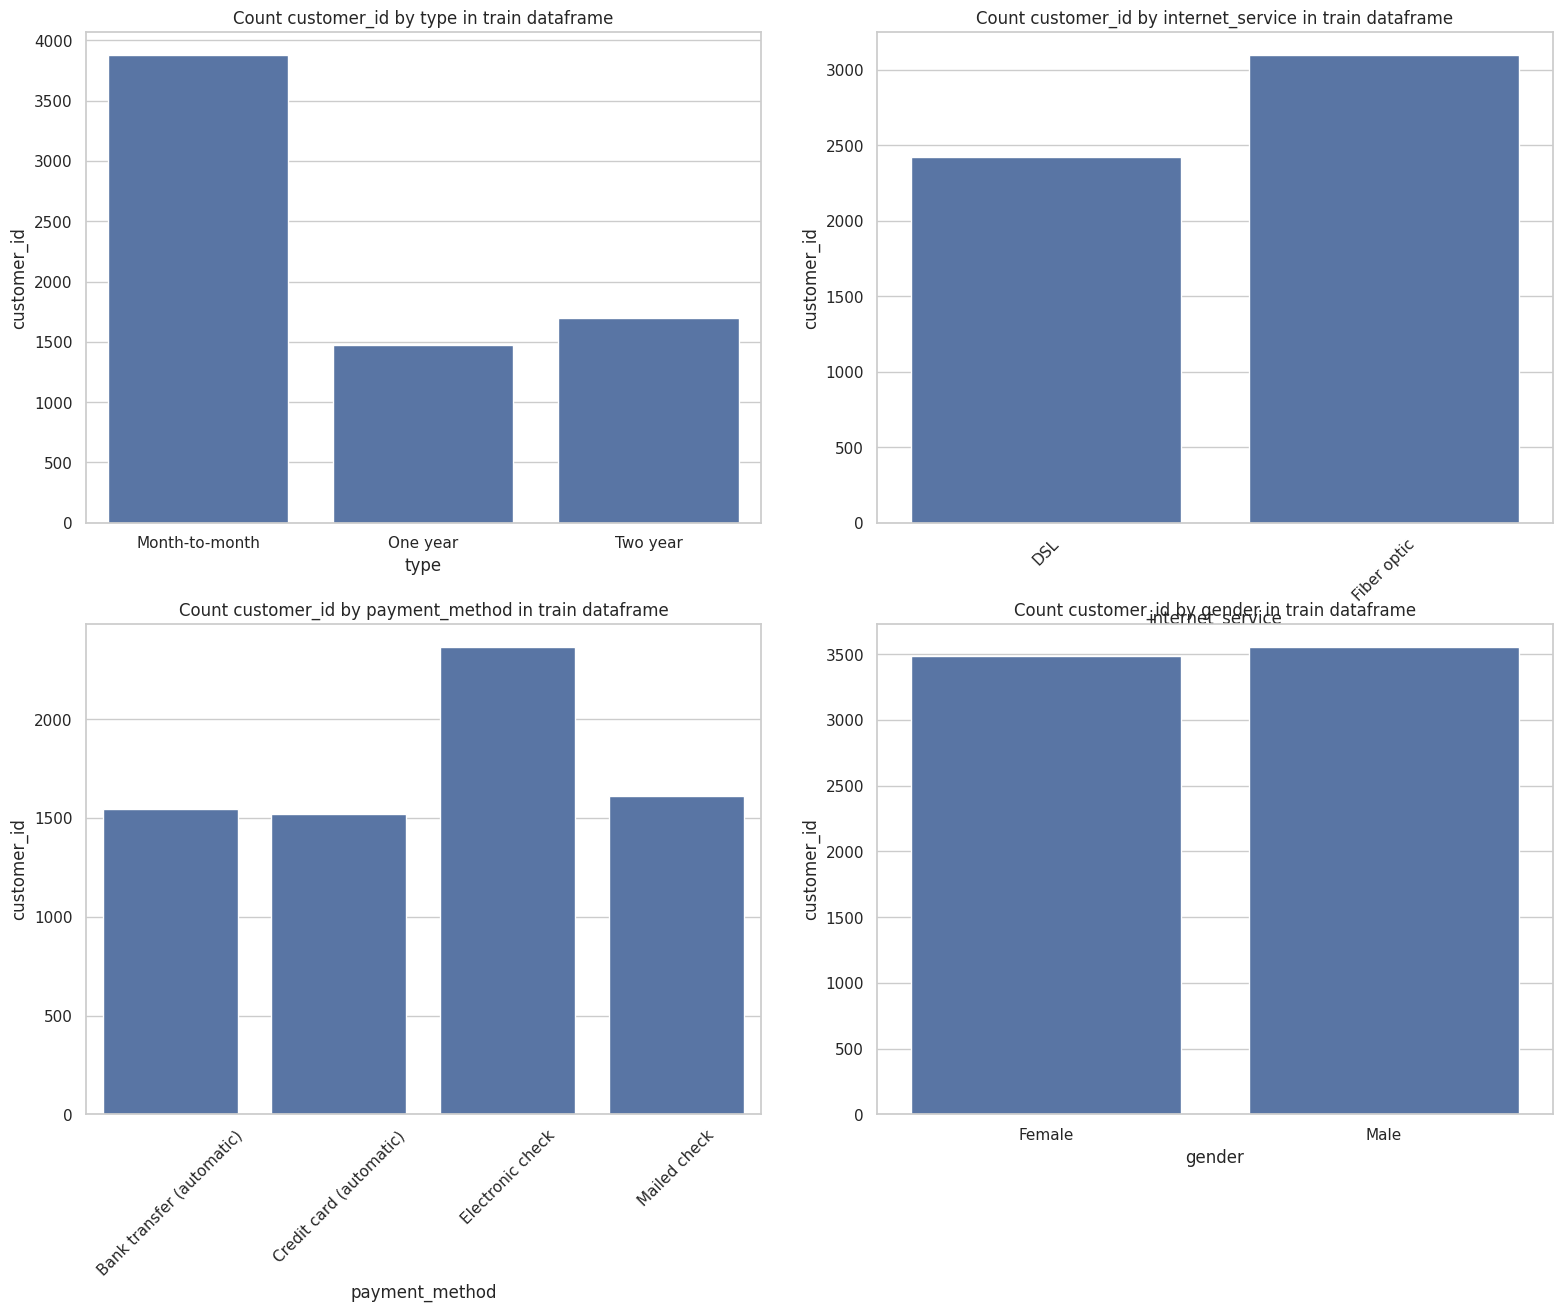

In [ ]:
# Subplots
fig, axs = plt.subplots(2, 2, figsize=(16.5, 12.5))
fig.tight_layout(pad=4)

# 1. Number of unique users by type
x = "type"
y = "customer_id"
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

# 2. Number of unique users by payment_method
x = "payment_method"
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(agg_df[x], rotation=45)

# 3. Number of unique users by по internet_service
x = "internet_service"
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_xticklabels(agg_df[x], rotation=45)

# 4. Number of unique users by gender
x = "gender"
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

# Save plot
save_path = os.path.join(ASSETS_DIR, "cat_features_1.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Show plot
plt.show()

In [ ]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]

stat = ['count']

print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

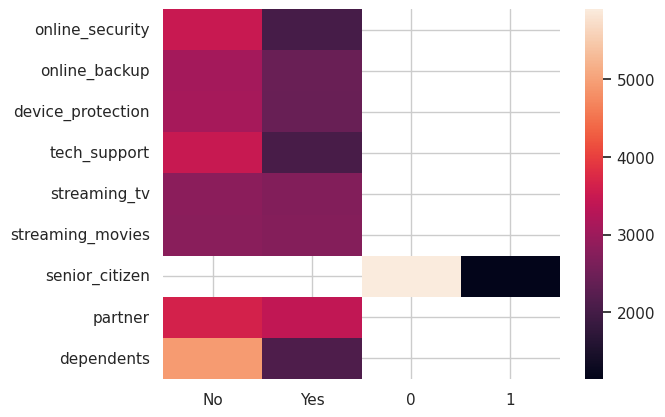

In [6]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

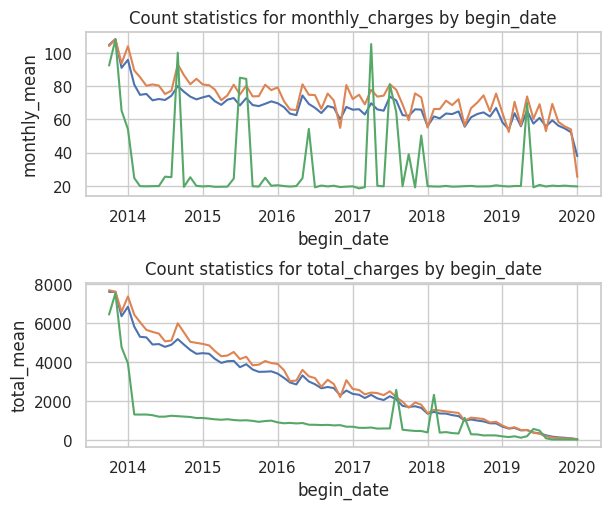

In [ ]:
# Column name variable
x = "begin_date"

# List of columns to use
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# Delete empty columns
df.dropna(subset=charges_columns, how='any', inplace=True)

# List of measurments to calculate
stats = ["mean", "median", lambda x: x.mode().iloc[0]]

# Group by date
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# Delete to row of indices
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# Rename the columns for convenience
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# Same for payments
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=2.5)
fig.set_size_inches(6.5, 5.5, forward=True)

sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')

axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# Save plot to file
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

Similarly, more statistics:

In [ ]:
ASSETS_DIR = "assets"
x = "target"

# Number of occurencies of each unique value
target_agg = df[x].value_counts().reset_index()

# Barplot
sns.barplot(data=target_agg, x='index', y='count')

plt.title(f"{x} total distribution")

# Save to file
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

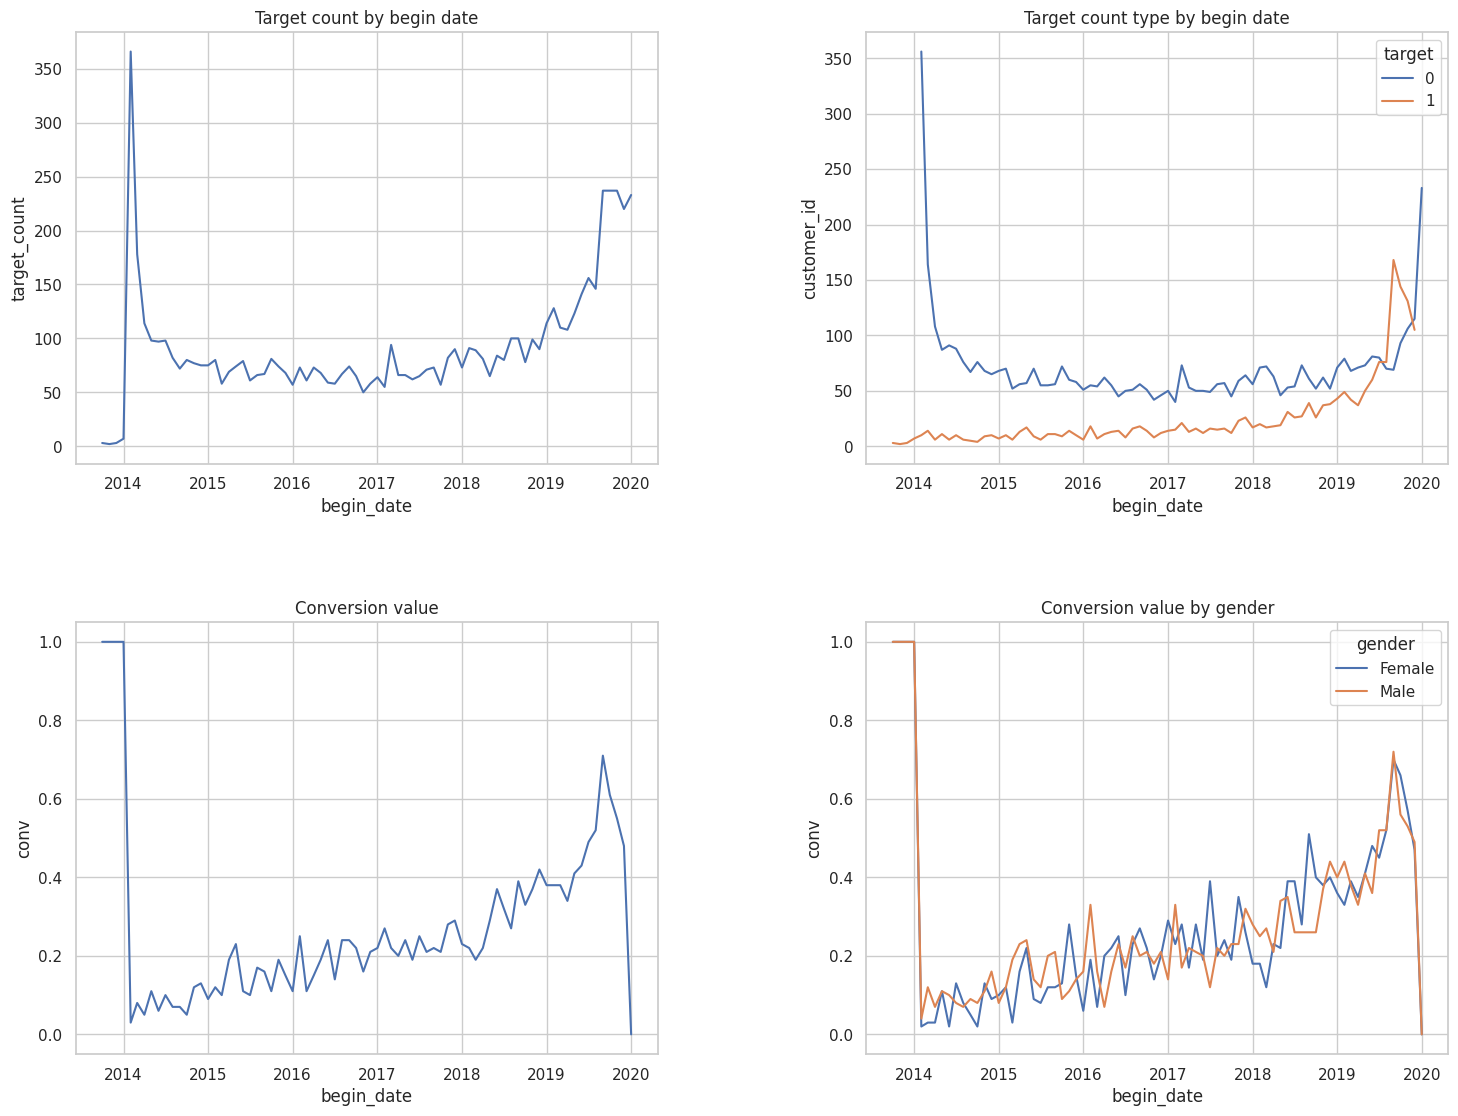

In [ ]:
x = "begin_date"
target = "target"

stat = ["count"]

# Number of goals by date
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# Number of clients for each goal
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# Conversion
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# Conversion coeff
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)

# Similarly, but for genders
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)

sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# Save to file
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

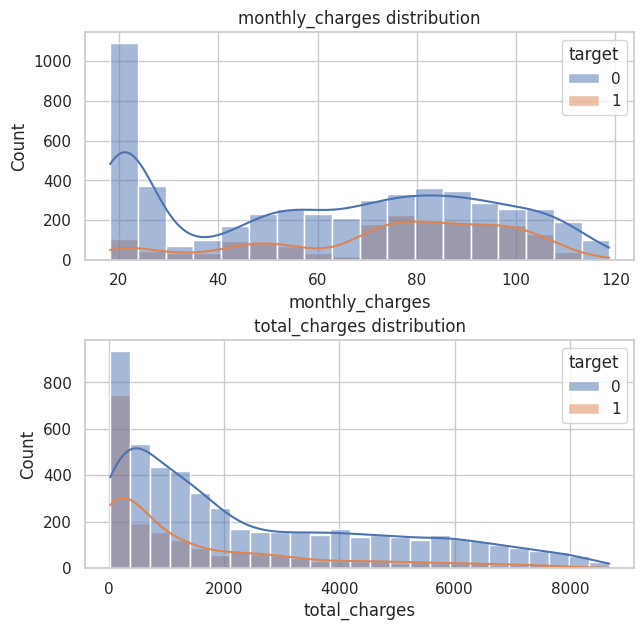

In [ ]:
charges = ["monthly_charges", "total_charges"]
target = "target"

fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)
fig.set_size_inches(6.5, 6.5, forward=True)

# Monthly payments by categories
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
axs[0].set_title(f"{charges[0]} distribution")

sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")

# Save plots to file
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))